# CS 1656 – Introduction to Data Science (Fall 2021) 

## Instructor: Alexandros Labrinidis
## Teaching Assistants: Evangelos Karageorgos, Xiaoting Li, Gordon Lu

## Term Project 

**Released: October 26, 2021**

**Due: November 30, 2021**

### Goal
The goal of this project is to expose you with a real data science problem, looking at the end-to-end pipeline. 

### What to do 
You are asked to write a Python Jupyter notebook, called `bikes_pgh_data.ipynb` that will:
* [Task 1] access historical bike rental data for 2021 from HealthyRidePGH and summarize the rental data  
* [Task 2] create graphs to show the popularity of the different rental stations, given filter conditions  
* [Task 3] create graphs to show the rebalancing issue  
* [Task 4] cluster the data to group similar stations together, using a variety of clustering functions and visualize the results of the clustering.  

**Your program should not take more than 15 minutes to run**

### Jupyter Notebook Rules
This skeleton is provided for you to complete the project. Please add your code in the code cells below each Task. Feel free to add cells as needed. Do not remove existing cells.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
from sklearn import cluster
from sklearn.cluster import DBSCAN
from pandas.plotting import register_matplotlib_converters
# Feel free to add here any other libraries as specified in the project description

For the sake of interactive display in Jupyter, we will enable matplotlib inline.

In [2]:
%matplotlib inline

### [Task 0] Warming Up
Task 0 is for testing. It is used to ensure that this Jupyter Notebook skeleton works on both your machines and our machine. Please run the following code to see if you can see a line plot. The line plot is the basic plot that we have seen in Recitation2. 

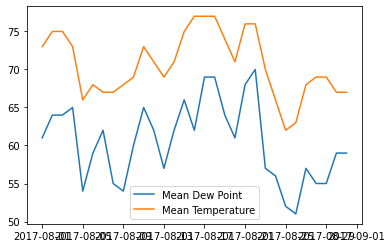

In [3]:

register_matplotlib_converters()
df = pd.read_csv('KPIT_Aug17.csv', sep=',', engine='python', parse_dates=['EST'])
p1 = plt.plot(df['EST'],df['MeanDew PointF'])
p2 = plt.plot(df['EST'],df['Mean TemperatureF'])
plt.legend([p1[0],p2[0]], ['Mean Dew Point', 'Mean Temperature'])

plt.show()

--- 
Add your code below this line

---
### Task 1

In this task you will need to access historical bike rental data for 2021 from HealthyRidePGH and summarize the rental data.

### Task 1.1

In [4]:
# Add all csv files to one dataframe
files = ['HealthyRideRentals2021-Q1.csv', 'HealthyRideRentals2021-Q2.csv', 'HealthyRideRentals2021-Q3.csv']
frames = [pd.read_csv(file) for file in files]
df = pd.concat(frames, axis=0, ignore_index=True)

# Convert starttime to date
df['Starttime'] = pd.to_datetime(df['Starttime'])

# Group the dataframe by from station and to station Ids along with date to get the count of each bike coming from and to each station for a given day
# Reset the index on the dataframe so the groupby function returns a dataframe and not a series
station_from_daily = df.groupby(['From station id',df['Starttime'].dt.strftime('%x')]).size().reset_index()
station_to_daily = df.groupby(['To station id',df['Starttime'].dt.strftime('%x')]).size().reset_index()

# Rename columns of each resulting dataframe
station_from_daily = station_from_daily.rename(columns={ station_from_daily.columns[0]: "stationId", station_from_daily.columns[2]: "fromCNT" })
station_to_daily = station_to_daily.rename(columns={station_to_daily.columns[0]: "stationId", station_to_daily.columns[2]: "toCNT"})

# perform an outer join of the from and 2 frames, filling nan values with 0. Sort values in df by stationID and starttime asc
daily_frame = pd.merge(station_from_daily, station_to_daily, on=["stationId", "Starttime"], how="outer").fillna(0)
daily_frame = daily_frame.sort_values(by=['stationId', "Starttime"], ascending=True)

# Add new column to the daily frame
daily_frame['rebalCNT'] = 0

# Reset index order
daily_frame.reset_index(drop=True, inplace=True)

# Loop through rows, counting the number of rebalances per day
prev_row = pd.Series()
# Sort original dataframe by bike and then date. Then format the date to match that of daily_frame
df = df.sort_values(by=["Bikeid", 'Starttime'], ascending=True)
df['Starttime'] = df['Starttime'].dt.strftime('%x')
for row in df.iterrows():
    # Ensure we are not on the first row in the dataframe
    if not prev_row.empty:
        # Ensure the bike IDs are the same
        if prev_row['Bikeid'] == row[1]['Bikeid']:
            # Ensure the to station of the previous row and the from station of the current row aren't NaN
            if not np.isnan(prev_row['To station id']) and not np.isnan(row[1]['From station id']):
                date = row[1]['Starttime']
                station = row[1]['From station id']
                # Check if previous to station and current from station are different. If they are, we need to increment the rebalance count
                if prev_row['To station id'] != station:
                    # Find the row in daily_frame and update the value
                    daily_frame.loc[(daily_frame['Starttime'] == date) & (daily_frame['stationId'] == station), 'rebalCNT'] += 1
    # Advance to next row
    prev_row = row[1]

# Display first 20 entires in the dataframe. Takes ~30 seconds to finish on my machine
print(daily_frame.head(20))



C:\Users\Stefon\AppData\Local\Temp/ipykernel_11692/587713522.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prev_row = pd.Series()


    stationId Starttime  fromCNT  toCNT  rebalCNT
0      1000.0  01/02/21      1.0    0.0         0
1      1000.0  01/03/21      0.0    1.0         0
2      1000.0  01/04/21      3.0    1.0         0
3      1000.0  01/05/21      2.0    2.0         0
4      1000.0  01/06/21      1.0    1.0         0
5      1000.0  01/07/21      2.0    1.0         0
6      1000.0  01/08/21      0.0    3.0         0
7      1000.0  01/10/21      3.0    3.0         0
8      1000.0  01/11/21      1.0    0.0         0
9      1000.0  01/12/21      1.0    3.0         0
10     1000.0  01/13/21      0.0    1.0         0
11     1000.0  01/14/21      1.0    3.0         0
12     1000.0  01/15/21      1.0    1.0         0
13     1000.0  01/16/21      0.0    1.0         0
14     1000.0  01/17/21      0.0    2.0         0
15     1000.0  01/18/21      1.0    1.0         0
16     1000.0  01/19/21      1.0    1.0         0
17     1000.0  01/23/21      5.0    1.0         1
18     1000.0  01/30/21      0.0    3.0         0


### Task 1.2

In [5]:
# Reset dataframe to get dates back to original format
df = pd.concat(frames, axis=0, ignore_index=True)

# Convert starttime to date
df['Starttime'] = pd.to_datetime(df['Starttime'])

# Group the dataframe by from station and to station Ids along with month to get the count of each bike coming from and to each station for a given day
# I grouped by month and not month, year since the data is only taken from 1 year
# Reset the index on the dataframe so the groupby function returns a dataframe and not a series
station_from_monthly = df.groupby(['From station id',df['Starttime'].dt.strftime('%B')]).size().reset_index()
station_to_monthly = df.groupby(['To station id',df['Starttime'].dt.strftime('%B')]).size().reset_index()

# Rename columns of each resulting dataframe
station_from_monthly = station_from_monthly.rename(columns={ station_from_monthly.columns[0]: "stationId", station_from_monthly.columns[2]: "fromCNT" })
station_to_monthly = station_to_monthly.rename(columns={station_to_monthly.columns[0]: "stationId", station_to_monthly.columns[2]: "toCNT"})

# perform an outer join of the from and 2 frames, filling nan values with 0. Sort values in df by stationID and starttime asc
monthly_frame = pd.merge(station_from_monthly, station_to_monthly, on=["stationId", "Starttime"], how="outer").fillna(0)
monthly_frame = monthly_frame.sort_values(by=['stationId', "Starttime"], ascending=True)

# Add new column to the monthly frame
monthly_frame['rebalCNT'] = 0

# Reset index order
monthly_frame.reset_index(drop=True, inplace=True)

# Loop through rows, counting the number of rebalances per station per month
prev_row = pd.Series()
# Sort original dataframe by bike and then date. Then format the date to match that of monthly_frame
df = df.sort_values(by=["Bikeid", 'Starttime'], ascending=True)
df['Starttime'] = df['Starttime'].dt.strftime('%B')
for row in df.iterrows():
    # Ensure we are not on the first row in the dataframe
    if not prev_row.empty:
        # Ensure the bike IDs are the same
        if prev_row['Bikeid'] == row[1]['Bikeid']:
            # Ensure the to station of the previous row and the from station of the current row aren't NaN
            if not np.isnan(prev_row['To station id']) and not np.isnan(row[1]['From station id']):
                date = row[1]['Starttime']
                station = row[1]['From station id']
                # Check if previous to station and current from station are different. If they are, we need to increment the rebalance count
                if prev_row['To station id'] != station:
                    # Find the row in monthly_frame and update the value
                    monthly_frame.loc[(monthly_frame['Starttime'] == date) & (monthly_frame['stationId'] == station), 'rebalCNT'] += 1
    # Advance to next row
    prev_row = row[1]

# Display first 20 entires in the dataframe. Takes ~20 seconds on my machine to complete
print(monthly_frame.head(20))

C:\Users\Stefon\AppData\Local\Temp/ipykernel_11692/2185328961.py:28: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prev_row = pd.Series()


    stationId  Starttime  fromCNT  toCNT  rebalCNT
0      1000.0      April    553.0  591.0         7
1      1000.0   February     33.0   36.0         6
2      1000.0    January     23.0   29.0         1
3      1000.0       June    811.0  832.0         6
4      1000.0      March    399.0  442.0         3
5      1000.0        May    834.0  882.0         4
6      1000.0  September    409.0  470.0         8
7      1001.0      April    236.0  255.0         5
8      1001.0   February     14.0   25.0         1
9      1001.0    January     18.0   27.0         0
10     1001.0       June    366.0  387.0         7
11     1001.0      March    180.0  221.0         4
12     1001.0        May    342.0  363.0         8
13     1001.0  September    234.0  252.0        10
14     1002.0      April    145.0  156.0         3
15     1002.0   February     27.0   28.0         3
16     1002.0    January     27.0   27.0         2
17     1002.0       June    144.0  153.0         4
18     1002.0      March    125

---
### Task 2

In this task you will need to create graphs to show the popularity of the different rental stations, given filter conditions.

In [6]:
# FILTER VARIABLES -- feel free to edit the values, but the names of the variables must remain 
#                     as they are and should be used by your code accordingly from this point on

filter_month = 4
filter_stationID = 1046



### Task 2.1

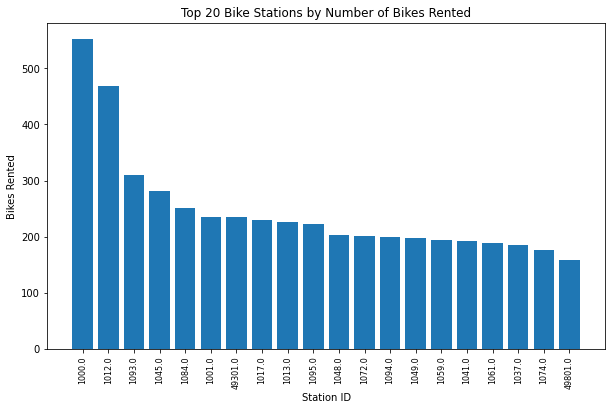

In [7]:
# Filter the monthly frame by the input month, then sort it by fromCNT and take the top 20 results
top_20_frame = monthly_frame[monthly_frame['Starttime'] == datetime.date(2021, filter_month, 1).strftime('%B')]
top_20_frame = top_20_frame.sort_values(by='fromCNT', ascending=False).head(20)

# Display bar graph
top_20_figure = plt.figure(figsize=(10, 6))
plt.bar(range(len(top_20_frame['stationId'])),top_20_frame['fromCNT'], align = 'center')

plt.xticks(range(len(top_20_frame['stationId'])), top_20_frame['stationId'],rotation = 90, fontsize = 8)
plt.xlabel('Station ID')
plt.ylabel('Bikes Rented')
plt.title('Top 20 Bike Stations by Number of Bikes Rented')

plt.show()

### Task 2.2

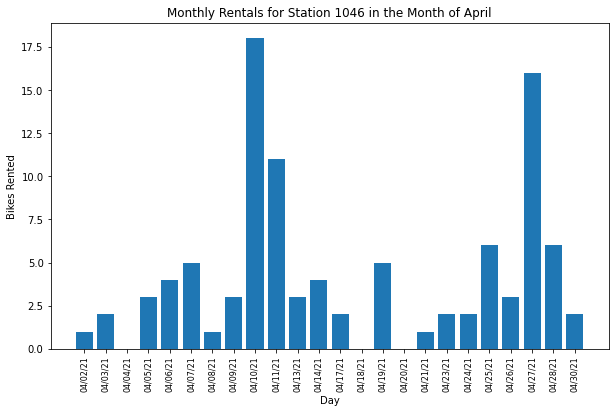

In [8]:
# Convert daily frame entries to datetime
daily_frame['Starttime'] = pd.to_datetime(daily_frame['Starttime'])


# Get all entries matching the filter station ID and month
station_monthly = daily_frame[daily_frame['stationId'] == filter_stationID]
station_monthly = station_monthly[station_monthly['Starttime'].dt.strftime('%B') == datetime.date(2021, filter_month, 1).strftime('%B')]

# Sort entries by day
station_monthly = station_monthly.sort_values(by="Starttime")

# Display bar graph
staion_monthly_figure = plt.figure(figsize=(10, 6))
plt.bar(range(len(station_monthly['stationId'])),station_monthly['fromCNT'], align = 'center')

plt.xticks(range(len(station_monthly['Starttime'])), station_monthly['Starttime'].dt.strftime('%x'), rotation = 90, fontsize = 8)
plt.xlabel('Day')
plt.ylabel('Bikes Rented')
plt.title('Monthly Rentals for Station ' + str(filter_stationID) + " in the Month of " + datetime.date(2021, filter_month, 1).strftime('%B'))

plt.show()


### Task 2.3

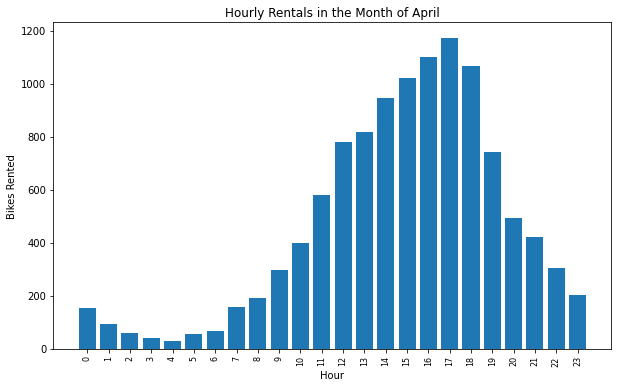

In [9]:
# Reset dataframe to get dates back to original format
df = pd.concat(frames, axis=0, ignore_index=True)

# Convert starttime to date
df['Starttime'] = pd.to_datetime(df['Starttime'])

# Get all entries in df that match the filter month
hourly_report = df[df['Starttime'].dt.strftime('%B') == datetime.date(2021, filter_month, 1).strftime('%B')]

# Group entries by hour and reset index
hourly_report = hourly_report.groupby([df['Starttime'].dt.hour]).size().reset_index()

hourly_report = hourly_report.rename(columns={ hourly_report.columns[0]: "Starttime", hourly_report.columns[1]: "fromCNT" })

# Display bar graph
hourly_figure = plt.figure(figsize=(10, 6))
plt.bar(range(len(hourly_report['Starttime'])),hourly_report['fromCNT'], align = 'center')

plt.xticks(range(len(hourly_report['Starttime'])), hourly_report['Starttime'], rotation = 90, fontsize = 8)
plt.xlabel('Hour')
plt.ylabel('Bikes Rented')
plt.title('Hourly Rentals in the Month of '+ datetime.date(2021, filter_month, 1).strftime('%B'))

plt.show()

### Task 2.4

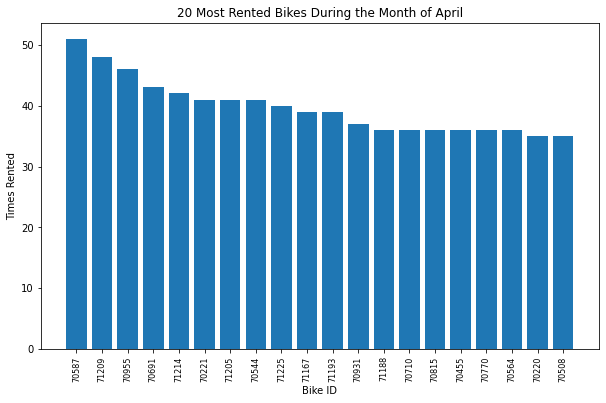

In [10]:
# Reset dataframe to get dates back to original format
df = pd.concat(frames, axis=0, ignore_index=True)

# Convert starttime to date
df['Starttime'] = pd.to_datetime(df['Starttime'])

# Get all entries in df that match the filter month
bike_report = df[df['Starttime'].dt.strftime('%B') == datetime.date(2021, filter_month, 1).strftime('%B')]

# Group entries by bike and reset the index
bike_report = bike_report.groupby([df['Bikeid']]).size().reset_index()

# Rename columns
bike_report = bike_report.rename(columns={ bike_report.columns[0]: "Bikeid", bike_report.columns[1]: "fromCNT" })

# Sort values by from count to get 20 most popular
bike_report = bike_report.sort_values(by='fromCNT', ascending=False).head(20)

# Display bar graph
bike_figure = plt.figure(figsize=(10, 6))
plt.bar(range(len(bike_report['Bikeid'])),bike_report['fromCNT'], align = 'center')

plt.xticks(range(len(bike_report['Bikeid'])), bike_report['Bikeid'], rotation = 90, fontsize = 8)
plt.xlabel('Bike ID')
plt.ylabel('Times Rented')
plt.title('20 Most Rented Bikes During the Month of '+ datetime.date(2021, filter_month, 1).strftime('%B'))

plt.show()

---
### Task 3

In this task you will create graphs to show the rebalancing issue.

### Task 3.1

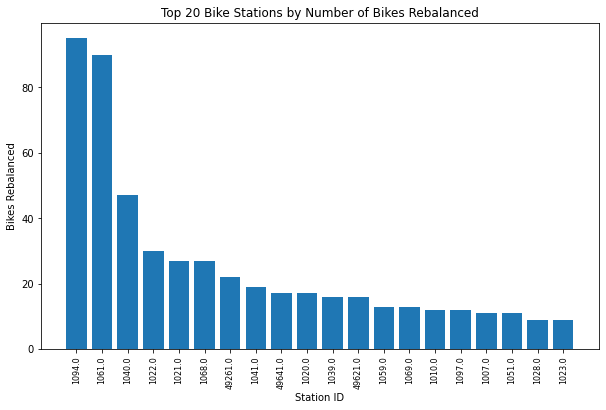

In [11]:
# Filter the monthly frame by the input month, then sort it by rebalCNT and take the top 20 results
top_20_rebal = monthly_frame[monthly_frame['Starttime'] == datetime.date(2021, filter_month, 1).strftime('%B')]
top_20_rebal = top_20_rebal.sort_values(by='rebalCNT', ascending=False).head(20)

# Display bar graph
rebal_figure = plt.figure(figsize=(10, 6))
plt.bar(range(len(top_20_rebal['stationId'])),top_20_rebal['rebalCNT'], align = 'center')

plt.xticks(range(len(top_20_rebal['stationId'])), top_20_rebal['stationId'],rotation = 90, fontsize = 8)
plt.xlabel('Station ID')
plt.ylabel('Bikes Rebalanced')
plt.title('Top 20 Bike Stations by Number of Bikes Rebalanced')

plt.show()

### Task 3.2

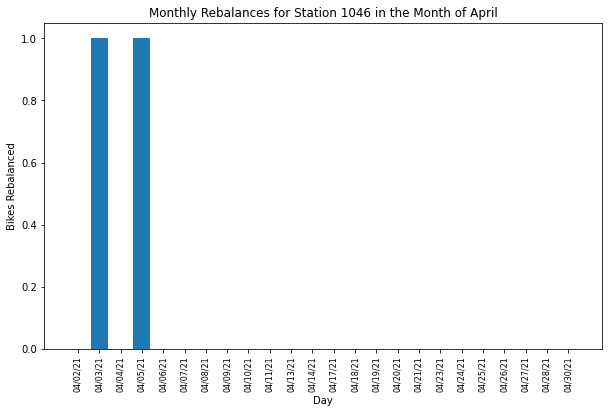

In [12]:
# Convert daily frame entries to datetime
daily_frame['Starttime'] = pd.to_datetime(daily_frame['Starttime'])

# Get all entries matching the filter station ID and month
rebalance_monthly = daily_frame[daily_frame['stationId'] == filter_stationID]
rebalance_monthly = rebalance_monthly[rebalance_monthly['Starttime'].dt.strftime('%B') == datetime.date(2021, filter_month, 1).strftime('%B')]

# Sort entries by day
rebalance_monthly = rebalance_monthly.sort_values(by="Starttime")

# Display bar graph
rebalance_monthly_figure = plt.figure(figsize=(10, 6))
plt.bar(range(len(rebalance_monthly['stationId'])),rebalance_monthly['rebalCNT'], align = 'center')

plt.xticks(range(len(rebalance_monthly['Starttime'])), rebalance_monthly['Starttime'].dt.strftime('%x'), rotation = 90, fontsize = 8)
plt.xlabel('Day')
plt.ylabel('Bikes Rebalanced')
plt.title('Monthly Rebalances for Station ' + str(filter_stationID) + " in the Month of " + datetime.date(2021, filter_month, 1).strftime('%B'))

plt.show()


---
### Task 4

In this task you will cluster the data to group similar stations together, using a variety of clustering functions and visualize the results of the clustering.

### Task 4.1

In [13]:
cluster_data = []
station_ids = monthly_frame['stationId'].unique()
for station in station_ids:
    station_frame = monthly_frame[monthly_frame['stationId'] == station]
    # Get rows from the monthly dataframe for April, May, and June for each station
    # Return values are in the form of a scalar series, so extract the number in them before adding it to the dict
    april_row = station_frame[station_frame['Starttime'] == datetime.date(2021, 4, 1).strftime('%B')]
    may_row = station_frame[station_frame['Starttime'] == datetime.date(2021, 5, 1).strftime('%B')]
    june_row = station_frame[station_frame['Starttime'] == datetime.date(2021, 6, 1).strftime('%B')]
    # Populate values from row if not empty, otherwise set to 0

    april_from = 0
    april_rebal = 0
    may_from = 0
    may_rebal = 0
    june_from = 0
    june_rebal = 0

    if not april_row.empty:
        april_from = april_row['fromCNT'].values[0]
        april_rebal = april_row['rebalCNT'].values[0]
    if not may_row.empty:
        may_from = may_row['fromCNT'].values[0]
        may_rebal = may_row['rebalCNT'].values[0]
    if not june_row.empty:
        june_from = june_row['fromCNT'].values[0]
        june_rebal = june_row['rebalCNT'].values[0]

    # Extract the fromCNT and rebalCNT for the above months for each station and then instert a dict entry into a list which will be used to make a new dataframe later
    cluster_data.append({'stationId': station, 'april_from': april_from, 'may_from': may_from, 'june_from': june_from, 'april_rebal': april_rebal, 'may_rebal': may_rebal, 'june_rebal': june_rebal})

# Create a dataframe from the list of dictionaries
cluster_frame = pd.DataFrame(cluster_data)
cluster_frame

# Create 3 different clustering objects with different k values
k_means_5 = cluster.KMeans(n_clusters=5, init = 'k-means++', random_state=5000)
k_means_4 = cluster.KMeans(n_clusters=4, init = 'k-means++', random_state=5000)
k_means_3 = cluster.KMeans(n_clusters=3, init = 'k-means++', random_state=5000)

# Execute k-means on the cluster frame for 3 different k values
k_means_5_res = k_means_5.fit(cluster_frame[['april_from', 'may_from', 'june_from', 'april_rebal', 'may_rebal', 'june_rebal']])
k_means_4_res = k_means_4.fit(cluster_frame[['april_from', 'may_from', 'june_from', 'april_rebal', 'may_rebal', 'june_rebal']])
k_means_3_res = k_means_3.fit(cluster_frame[['april_from', 'may_from', 'june_from', 'april_rebal', 'may_rebal', 'june_rebal']])

# Execute DBSCAN on the cluster frame for 3 different combinations of eps and min_samples values
db_1 = DBSCAN(eps=7, min_samples=2).fit(cluster_frame[['april_from', 'may_from', 'june_from', 'april_rebal', 'may_rebal', 'june_rebal']])
db_2 = DBSCAN(eps=8, min_samples=4).fit(cluster_frame[['april_from', 'may_from', 'june_from', 'april_rebal', 'may_rebal', 'june_rebal']])
db_3 = DBSCAN(eps=9, min_samples=6).fit(cluster_frame[['april_from', 'may_from', 'june_from', 'april_rebal', 'may_rebal', 'june_rebal']])

### Task 4.2

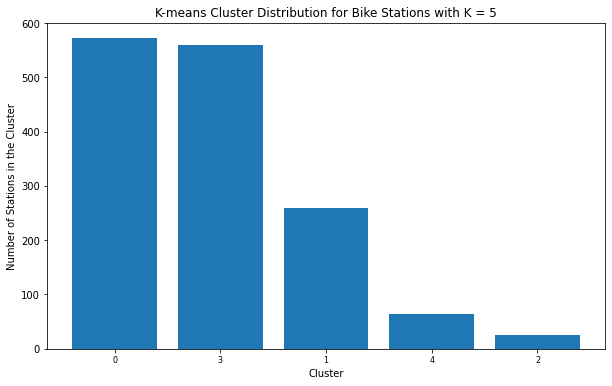

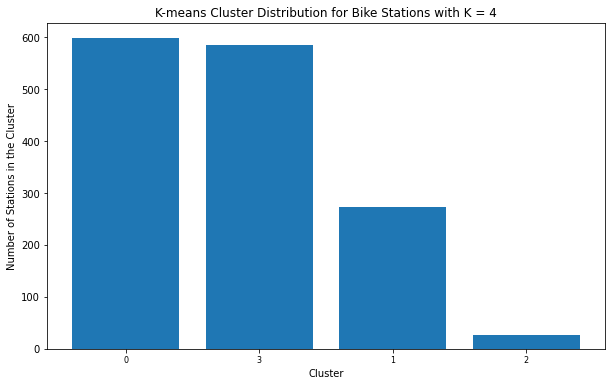

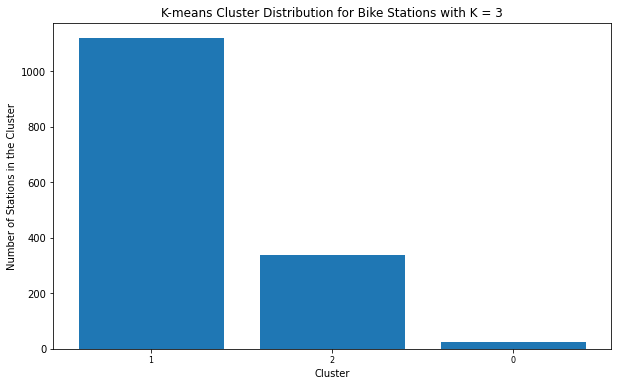

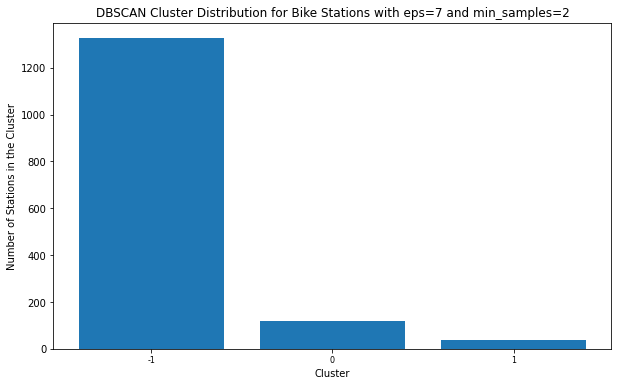

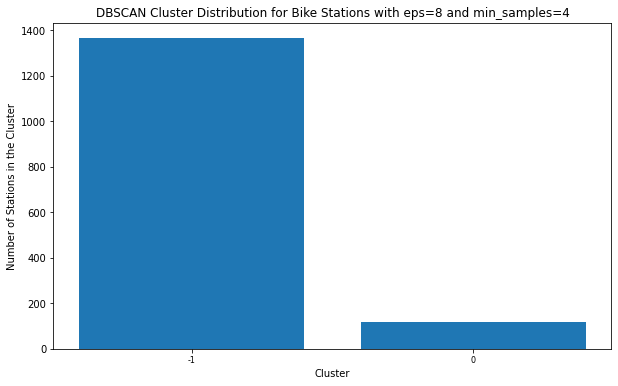

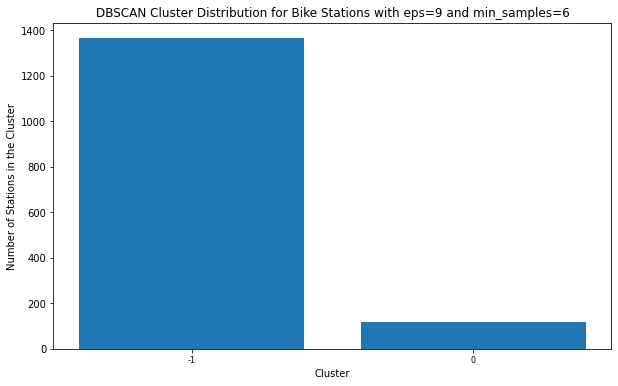

In [14]:
cluster_frame['k_means_5'] = pd.Series(k_means_5_res.labels_, index=cluster_frame.index)
cluster_frame['k_means_4'] = pd.Series(k_means_4_res.labels_, index=cluster_frame.index)
cluster_frame['k_means_3'] = pd.Series(k_means_3_res.labels_, index=cluster_frame.index)
cluster_frame['db_1'] = pd.Series(db_1.labels_, index=cluster_frame.index)
cluster_frame['db_2'] = pd.Series(db_2.labels_, index=cluster_frame.index)
cluster_frame['db_3'] = pd.Series(db_3.labels_, index=cluster_frame.index)

# Print graph for k-means with k = 5
cluster_counts = {}
# Get dict of cluster and # of rows with that cluster label
clusters = cluster_frame['k_means_5'].unique()
for kcluster in clusters:
    group = cluster_frame[cluster_frame['k_means_5'] == kcluster]
    cluster_counts[kcluster] = group.size

cluster_counts = dict(sorted(cluster_counts.items(), key=lambda item: item[1], reverse=True))

# Display bar graph 
k_means_5_graph = plt.figure(figsize=(10, 6))
plt.bar(range(len(cluster_counts.keys())), cluster_counts.values(), align = 'center')

plt.xticks(range(len(cluster_counts.keys())), cluster_counts.keys(), fontsize = 8)
plt.xlabel('Cluster')
plt.ylabel('Number of Stations in the Cluster')
plt.title('K-means Cluster Distribution for Bike Stations with K = 5')

plt.show()

# Print graph for k-means with k = 4
cluster_counts = {}
clusters = cluster_frame['k_means_4'].unique()
for kcluster in clusters:
    group = cluster_frame[cluster_frame['k_means_4'] == kcluster]
    cluster_counts[kcluster] = group.size

cluster_counts = dict(sorted(cluster_counts.items(), key=lambda item: item[1], reverse=True))

# Display bar graph 
k_means_4_graph = plt.figure(figsize=(10, 6))
plt.bar(range(len(cluster_counts.keys())), cluster_counts.values(), align = 'center')

plt.xticks(range(len(cluster_counts.keys())), cluster_counts.keys(), fontsize = 8)
plt.xlabel('Cluster')
plt.ylabel('Number of Stations in the Cluster')
plt.title('K-means Cluster Distribution for Bike Stations with K = 4')

plt.show()

# Print graph for k-means with k = 3
cluster_counts = {}
clusters = cluster_frame['k_means_3'].unique()
for kcluster in clusters:
    group = cluster_frame[cluster_frame['k_means_3'] == kcluster]
    cluster_counts[kcluster] = group.size

cluster_counts = dict(sorted(cluster_counts.items(), key=lambda item: item[1], reverse=True))

# Display bar graph 
k_means_3_graph = plt.figure(figsize=(10, 6))
plt.bar(range(len(cluster_counts.keys())), cluster_counts.values(), align = 'center')

plt.xticks(range(len(cluster_counts.keys())), cluster_counts.keys(), fontsize = 8)
plt.xlabel('Cluster')
plt.ylabel('Number of Stations in the Cluster')
plt.title('K-means Cluster Distribution for Bike Stations with K = 3')

plt.show()

# Print graph for DBSCAN with eps=7 and min_samples=2
cluster_counts = {}
clusters = cluster_frame['db_1'].unique()
for dbcluster in clusters:
    group = cluster_frame[cluster_frame['db_1'] == dbcluster]
    cluster_counts[dbcluster] = group.size

cluster_counts = dict(sorted(cluster_counts.items(), key=lambda item: item[1], reverse=True))

# Display bar graph 
db_1_graph = plt.figure(figsize=(10, 6))
plt.bar(range(len(cluster_counts.keys())), cluster_counts.values(), align = 'center')

plt.xticks(range(len(cluster_counts.keys())), cluster_counts.keys(), fontsize = 8)
plt.xlabel('Cluster')
plt.ylabel('Number of Stations in the Cluster')
plt.title('DBSCAN Cluster Distribution for Bike Stations with eps=7 and min_samples=2')

plt.show()

# Print graph for DBSCAN with eps=8 and min_samples=4
cluster_counts = {}
clusters = cluster_frame['db_2'].unique()
for dbcluster in clusters:
    group = cluster_frame[cluster_frame['db_2'] == dbcluster]
    cluster_counts[dbcluster] = group.size

cluster_counts = dict(sorted(cluster_counts.items(), key=lambda item: item[1], reverse=True))

# Display bar graph 
db_2_graph = plt.figure(figsize=(10, 6))
plt.bar(range(len(cluster_counts.keys())), cluster_counts.values(), align = 'center')

plt.xticks(range(len(cluster_counts.keys())), cluster_counts.keys(), fontsize = 8)
plt.xlabel('Cluster')
plt.ylabel('Number of Stations in the Cluster')
plt.title('DBSCAN Cluster Distribution for Bike Stations with eps=8 and min_samples=4')

plt.show()

# Print graph for DBSCAN with eps=9and min_samples=6
cluster_counts = {}
clusters = cluster_frame['db_3'].unique()
for dbcluster in clusters:
    group = cluster_frame[cluster_frame['db_3'] == dbcluster]
    cluster_counts[dbcluster] = group.size

cluster_counts = dict(sorted(cluster_counts.items(), key=lambda item: item[1], reverse=True))

# Display bar graph 
db_3 = plt.figure(figsize=(10, 6))
plt.bar(range(len(cluster_counts.keys())), cluster_counts.values(), align = 'center')

plt.xticks(range(len(cluster_counts.keys())), cluster_counts.keys(), fontsize = 8)
plt.xlabel('Cluster')
plt.ylabel('Number of Stations in the Cluster')
plt.title('DBSCAN Cluster Distribution for Bike Stations with eps=9 and min_samples=6')

plt.show()




### Task 4.3

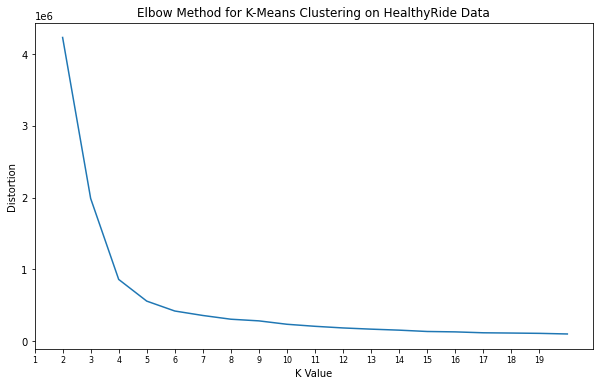

In [15]:
distortions = []
test_k_values = range(1, 20)
for k in test_k_values:
    # For each k value between 1 and 20, create a KMeans cluster and calculate the distortion associated with it
    test_model = cluster.KMeans(n_clusters = k)
    test_model.fit(cluster_frame[['april_from', 'may_from', 'june_from', 'april_rebal', 'may_rebal', 'june_rebal']])
    distortions.append(test_model.inertia_)

# Plot results of elbow method
distortion_figure = plt.figure(figsize=(10, 6))
plt.plot(test_k_values, distortions)
plt.xticks(range(len(test_k_values)), test_k_values, fontsize = 8)
plt.xlabel('K Value')
plt.ylabel('Distortion')
plt.title('Elbow Method for K-Means Clustering on HealthyRide Data')
plt.show()

# As you can see from the elbow method above, the top 3 K values that I chose for the dataset are 3, 4, and 5. Utilizing few clusters than this would 
# lead to a high distortion while choosing more clusters would offer marginal benefits. Out of the 3 K values I chose, 5 would be the optimal value
# as after 5 the benefit of more clusters decreases dramatically, while the jump from 4 to 5 clusters is still noticeable.

# From the graphs in task 4.2, I would argue that K-means was the best algorithm for this dataset. This is because DBSCAN labelled most of my data as noise,
# while K-Means was able to categorize all of the data.